In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List
import numpy as np
import pandas as pd
import itertools
from itertools import combinations_with_replacement


import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

%matplotlib inline
%matplotlib ipympl

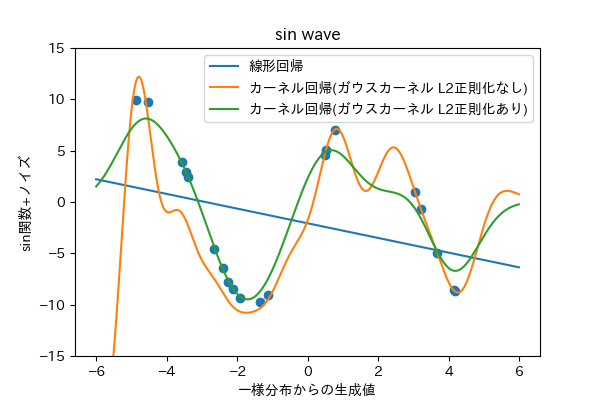

In [3]:
def wave_dataset(size:int, xlim:List=[0, 1], scale:float|None=None) -> pd.DataFrame:
    x = np.random.uniform(xlim[0], xlim[1], size)
    y = 10*np.sin(x)
    if scale is not None:
        noize = np.random.normal(0, scale, size)
        y = y + noize
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    return df

def gauss_kernel(xi, xj, beta=1):
    return np.exp(- beta * np.sum((xi - xj)**2))

def gauss_kernel_predict(xi:np.float64, xj_list:List, beta=1):
    predict = np.array([gauss_kernel(xi, xj, beta=beta) for xj in xj_list])
    return predict

train_num  = 20
train_data = wave_dataset(train_num, xlim=[-5, 5], scale=0.1)
X_axis     = np.arange(-6, 6, 0.01)

# 線形回帰
A     = np.hstack([train_data['x'].values.reshape(-1, 1), np.ones([train_num, 1])])
w_hat = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, train_data['y'].values))
y_hat = np.dot(np.hstack([X_axis.reshape(-1, 1), np.ones([len(X_axis), 1])]), w_hat)

# ガウスカーネル回帰
Kernel = np.zeros((train_num, train_num))
for i, j in combinations_with_replacement(range(train_num), 2):
    Kernel[i][j] = gauss_kernel(train_data['x'].values[i], train_data['x'].values[j])
    Kernel[j][i] = Kernel[i][j]

# メモ：
# 下記のサイトによれば重み係数wを推定できるとしているが、「ガウス過程と機械学習(機械学習プロフェッショナルシリーズ)」によれば重み係数wは積分消去されているはずである
# どうやら、「ガウスカーネル」と一言に表現してもさまざまな考え方が存在しているらしい
# 一旦は、Qiitaに記載されている通りのアルゴリズムで推定処理を行うこととする
# 
# 線形な手法とカーネル法（回帰分析）- Qiita
# https://qiita.com/wsuzume/items/09a59036c8944fd563ff

# ガウスカーネル回帰(L2正則化なし)
x_dash1 = np.dot(np.linalg.inv(np.dot(Kernel, Kernel)), np.dot(Kernel, train_data['y'].values))
y_dash1 = np.sum([x_dash1[idx] * gauss_kernel_predict(elem, X_axis) for idx, elem in enumerate(train_data['x'].values)], axis=0)
# ガウスカーネル回帰(L2正則化あり)
x_dash2 = np.dot(np.linalg.inv(np.dot(Kernel, Kernel) + 1 * np.eye(train_num)), np.dot(Kernel, train_data['y'].values))
y_dash2 = np.sum([x_dash2[idx] * gauss_kernel_predict(elem, X_axis) for idx, elem in enumerate(train_data['x'].values)], axis=0)

# データを描画
plt.figure(figsize=(6, 4))
plt.plot(X_axis, y_hat,   label='線形回帰')
plt.plot(X_axis, y_dash1, label='カーネル回帰(ガウスカーネル L2正則化なし)')
plt.plot(X_axis, y_dash2, label='カーネル回帰(ガウスカーネル L2正則化あり)')
plt.scatter(train_data['x'].values, train_data['y'].values, marker='o')
plt.title('sin wave')
plt.xlabel('一様分布からの生成値')
plt.ylabel('sin関数+ノイズ')
plt.ylim((-1.5*10, 1.5*10))
plt.legend()
plt.show()

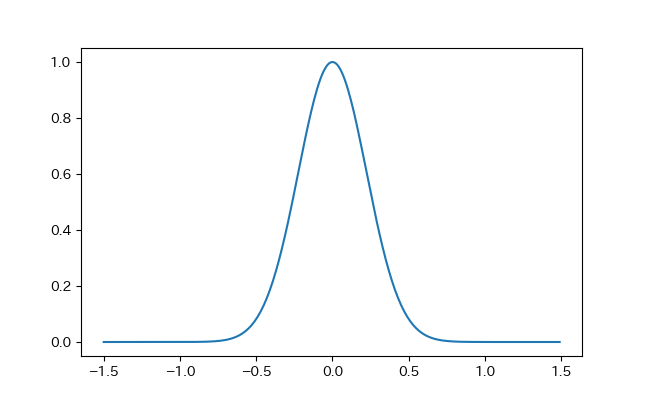

In [4]:
def kernel(xi, xj, beta=1):
    return np.exp(- beta * np.sum((xi - xj)**2))

X = np.arange(-1.5, 1.5, 0.01)
Y = np.zeros(len(X))
for i in range(len(X)):
    Y[i] = kernel(X[i], 0, 10)

plt.figure(figsize=(6.472, 4))
plt.plot(X, Y)
plt.show()

idx:0
diff: 191.4978985891396
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

idx:10000
diff: 84.75345289427733
[0.40837287 0.15126182 0.99540321 0.30557053 0.32568376 0.57027891
 0.33417652 0.8263738  0.00836845]

idx:20000
diff: 110.16072804102086
[0.32652265 0.07926663 1.2768797  0.17600999 0.21247729 0.80353362
 0.34828479 1.72889324 0.00349578]

idx:30000
diff: 19.273446557146745
[0.25350131 0.05443637 1.35314223 0.20785131 0.2813554  0.99967457
 0.25215327 2.72941555 0.00471664]

idx:40000
diff: 10.546455873553409
[0.18935189 0.03979303 1.38023487 0.27632036 0.36581633 0.99168464
 0.17445431 3.499542   0.00581232]

idx:50000
diff: 6.980606731520886
[0.13420658 0.02720415 1.39704845 0.34421422 0.39525697 0.98695871
 0.10066291 4.06718962 0.00699172]

idx:60000
diff: 5.58313378556765
[0.08827669 0.015088   1.42721158 0.41266324 0.38264343 0.98407058
 0.04755472 4.50361589 0.00834824]

idx:70000
diff: 4.1142146320086175
[0.05177555 0.00594378 1.47372031 0.48781197 0.3508598  0.9825617
 0.017

/var/folders/xt/sjm9fswx5fsbx8zythb79vbm0000gp/T/ipykernel_44013/3645631720.py:106: RuntimeWarning: invalid value encountered in sqrt
  var_dash1 = np.diag(np.sqrt(K_own - K_cros @ np.linalg.inv(K_data) @ K_cros.T))


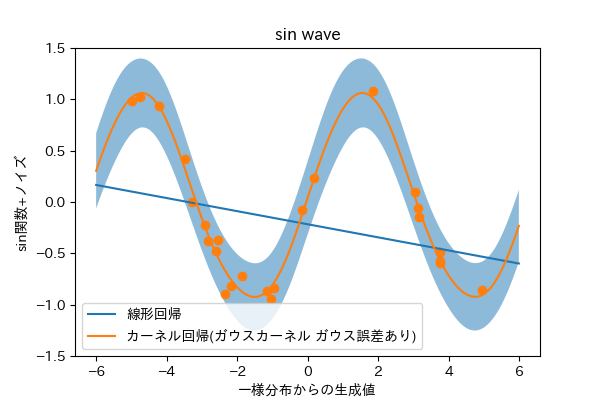

In [6]:
# メモ：
# ガウス過程と機械学習 著.餅橋大地
# この参考書を元にガウスカーネルによる予測分布を構築していくこととする
# 
# どうやら、Qiitaに記されていたガウスカーネルと青本に記されていたガウスカーネルは同じものを指すようだ
# 予測するアルゴリズムが一見すると全く違うため、違う概念であると勘違いをしていた
# しかし、青本の通りに実装してもまともに予測することができなかった
# L2正則化項を付加することで、予測することができるようになった
# 今後はこのことに気をつけつつ、モデルを設計しなければならない

def wave_dataset(size:int, xlim:List=[0, 1], scale:float|None=None) -> pd.DataFrame:
    x = np.random.uniform(xlim[0], xlim[1], size)
    y = 1*np.sin(x)
    if scale is not None:
        noize = np.random.normal(0, scale, size)
        y = y + noize
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    return df

def kronecker_delta(N:int) -> np.ndarray:
	return np.eye(N)

def linear_kernel(xi:np.ndarray, xj:np.ndarray) -> np.ndarray:
    return xi * xj

def exponential_kernel(xi:np.ndarray, xj:np.ndarray, beta=1) -> np.ndarray:
    return np.exp(-np.abs(xi - xj) / beta)

def periodic_kernel(xi:np.ndarray, xj:np.ndarray, beta=[1, 1]) -> np.ndarray:
	return np.exp(beta[0] * np.cos(np.abs(xi - xj) / beta[1]))

def gauss_kernel(xi:np.ndarray, xj:np.ndarray, beta=1) -> np.ndarray:
    return np.exp(-((xi - xj)**2 / beta))

def model_kernel(xi:np.ndarray, xj:np.ndarray, beta=[1, 1, 1, 1, 1, 1, 1, 1, 1]) -> np.ndarray:
    K_linea = beta[0] * linear_kernel(     xi, xj)
    K_expon = beta[1] * exponential_kernel(xi, xj, beta=beta[2])
    K_perio = beta[3] * periodic_kernel(   xi, xj, beta=[beta[4], beta[5]])
    K_gauss = beta[6] * gauss_kernel(      xi, xj, beta=beta[7])
    K_noise = beta[8] * kronecker_delta(   xi.shape[0])
    return K_linea + K_expon + K_perio + K_gauss + K_noise

def diff_model_kernel(y:np.ndarray, kernel:np.ndarray, xi:np.ndarray, xj:np.ndarray, beta=[1, 1, 1, 1, 1, 1, 1, 1, 1]) -> List[np.ndarray]:
    CONST1 = np.linalg.inv(kernel)
    CONST2 = CONST1 @ y
    theta0 = linear_kernel(xi, xj)
    theta1 = exponential_kernel(xi, xj, beta=beta[2])
    theta2 = exponential_kernel(xi, xj, beta=beta[2]) * beta[1] * (np.abs(xi - xj) / (beta[2]**2))
    theta3 = periodic_kernel(   xi, xj, beta=[beta[4], beta[5]])
    theta4 = periodic_kernel(   xi, xj, beta=[beta[4], beta[5]]) * beta[3] * np.cos(np.abs(xi - xj) / beta[5])
    theta5 = periodic_kernel(   xi, xj, beta=[beta[4], beta[5]]) * beta[3] * beta[4] * np.abs(xi - xj) / (beta[5]**2) * np.sin(np.abs(xi - xj) / beta[5])
    theta6 = gauss_kernel(      xi, xj, beta=beta[7])
    theta7 = gauss_kernel(      xi, xj, beta=beta[7]) * beta[6] * (((xi - xj) / beta[7])**2)
    theta8 = kronecker_delta(   xi.shape[0])
	
    theta0 = (-np.trace(CONST1 @ theta0) + CONST2.T @ theta0 @ CONST2) * beta[0]
    theta1 = (-np.trace(CONST1 @ theta1) + CONST2.T @ theta1 @ CONST2) * beta[1]
    theta2 = (-np.trace(CONST1 @ theta2) + CONST2.T @ theta2 @ CONST2) * beta[2]
    theta3 = (-np.trace(CONST1 @ theta3) + CONST2.T @ theta3 @ CONST2) * beta[3]
    theta4 = (-np.trace(CONST1 @ theta4) + CONST2.T @ theta4 @ CONST2) * beta[4]
    theta5 = (-np.trace(CONST1 @ theta5) + CONST2.T @ theta5 @ CONST2) * beta[5]
    theta6 = (-np.trace(CONST1 @ theta6) + CONST2.T @ theta6 @ CONST2) * beta[6]
    theta7 = (-np.trace(CONST1 @ theta7) + CONST2.T @ theta7 @ CONST2) * beta[7]
    theta8 = (-np.trace(CONST1 @ theta8) + CONST2.T @ theta8 @ CONST2) * beta[8]
    return np.array([theta0, theta1, theta2, theta3, theta4, theta5, theta6, theta7, theta8])

train_num  = 25
train_data = wave_dataset(train_num, xlim=[-5, 5], scale=0.1)
X_axis     = np.arange(-6, 6, 0.01)

# 線形回帰
A     = np.hstack([train_data['x'].values.reshape(-1, 1), np.ones([train_num, 1])])
w_hat = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, train_data['y'].values))
y_hat = np.dot(np.hstack([X_axis.reshape(-1, 1), np.ones([len(X_axis), 1])]), w_hat)


thetas = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
for idx in range(0, 10000000):
	tmp_thetas  = (thetas ** 2) / 2
	INPUT       = np.tile(train_data['x'].values, (train_num, 1))
	Kernel      = model_kernel(INPUT, INPUT.T, beta=tmp_thetas.tolist())
	diff_thetas = diff_model_kernel(train_data['y'].values, Kernel, INPUT, INPUT.T, beta=tmp_thetas.tolist())
	thetas      = thetas + 0.00001 * diff_thetas
    
	if np.sum(diff_thetas**2) < 1e-1:
		break
    
	if idx % 10000 == 0:
		print(f'idx:{idx}')
		print(f'diff: {np.sum(diff_thetas**2)}')
		print(tmp_thetas)
		print()


# ガウスカーネル回帰
tmp_thetas  = (thetas ** 2) / 2
Kernel = np.append(train_data['x'].values, X_axis)
Kernel = np.tile(Kernel, (len(Kernel), 1))
Kernel = model_kernel(Kernel, Kernel.T, beta=tmp_thetas.tolist())
K_data = Kernel[0:train_num, 0:train_num]
K_cros = Kernel[train_num::, 0:train_num]
K_own  = Kernel[train_num::, train_num::]
y_dash1   = K_cros @ np.linalg.inv(K_data) @ train_data['y'].values
var_dash1 = np.diag(np.sqrt(K_own - K_cros @ np.linalg.inv(K_data) @ K_cros.T))

# データを描画
plt.figure(figsize=(6, 4))
plt.plot(X_axis, y_hat,   label='線形回帰')
plt.plot(X_axis, y_dash1, label='カーネル回帰(ガウスカーネル ガウス誤差あり)')
plt.fill_between(X_axis, y_dash1 - 3*var_dash1, y_dash1 + 3*var_dash1, alpha=0.5)
plt.scatter(train_data['x'].values, train_data['y'].values, marker='o')
plt.title('sin wave')
plt.xlabel('一様分布からの生成値')
plt.ylabel('sin関数+ノイズ')
plt.ylim((-1.5*1, 1.5*1))
plt.legend()
plt.show()